# Toxic Comment Classification

## Objective

Discussions on communities are difficult when there is a threat of harrasment, abuse. This will make the people to stop express themselves and to seek opininons from these platforms. These forums find difficulty to ease communications which is leading to remove the commenting feature from their communities

This projects aim to classify comments in the wikipedia talks page based on their toxicity levels like toxic, identity hate , severe toxic, obscene, threat and insult. Proper models will help online communities to deliver fruitful service to the users. 

## Dataset

Dataset is from wikipedias talk page. Since the data can belong to multiple label simultaneously this is a multi label classifier.
Kaggle link for the dataset [1] - https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge

### Importing Required Libraries

Import the required packages and libraries needed for this project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import nltk
import string
import re
import warnings
import wordcloud

warnings.filterwarnings('ignore')

from wordcloud import WordCloud 
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# import classifiers metrices and plots
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix,f1_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold


In [6]:
# Stopwords are the words that are not necessary to create features of a sentence
stopword = set(stopwords.words('english'))  # Assign the English stopwords to a variable
print(stopword) # print stopwords to see 

{'myself', 'both', 'ain', 'after', 'not', 'mightn', 'me', 'it', 'were', 'has', 'to', 'on', 'or', 'her', "won't", 'itself', 'which', 'with', 'other', 'under', 'yourselves', 'them', 'are', "haven't", 'as', 'had', 'when', 'you', 'they', 'doesn', 'haven', 'off', "aren't", 'above', 'same', 'against', 'having', 'that', 'a', 'their', 'was', 'from', "you'll", "shouldn't", 'an', 'our', 'for', 'once', 'most', 'can', 'couldn', 'himself', 'isn', 's', 'him', 'where', 'mustn', 'don', 'into', 'y', 'aren', "mightn't", 'did', 'ma', 'o', 'and', "weren't", 'before', 'shan', 'now', 'wouldn', 'up', 'wasn', 'nor', 'the', "don't", 'in', "hadn't", 'again', 'between', 'any', 'we', 'only', 're', 'didn', "didn't", 'who', 'doing', 'while', 'so', 'shouldn', "it's", 'yourself', 'there', "she's", 'herself', 'his', 'if', 'down', 'some', 'hers', 'been', 'here', 'of', 'own', 'through', 'needn', 'its', 'my', 'why', "you're", "couldn't", 'is', "shan't", "you'd", 'about', 'have', 'hasn', 'no', 'be', "doesn't", 'ours', 've

## Exploratory Data Analysis

Read data from the csv file and visualise using various plots

### Data Loading

In [7]:
# Read the data and display first 10 rows

data = pd.read_csv('train.csv')
data.head(10) # visualize first 10 data of the input

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


**We have data in the comment_text column as independent variable and other 6 columns from toxic to identity_hate as our dependent variables.
Rows that are having values 0 for all the 6 categories are non-toxic comments**

In [19]:
data.info() # gives the information about the data 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


* Dataset is clean with no null values so we dont want to do any cleaning methods.

There are six labels in out dataset and comments that are not present in any of these labels can be classified as non_toxic comments.

##### Display the number of comments in each label

In [8]:
rowsum=data.iloc[:,2:].sum(axis=1)
data['non_toxic']=(rowsum==0) # Check whether data is non_toxic and assign a boolean value in the non_toxic column 
data['non_toxic']=data['non_toxic'].astype(int) # Convert the boolean value in the non_toxic value to 0 or 1

In [9]:
# find number of comments in each category
data.iloc[:,2:].sum()

toxic             15294
severe_toxic       1595
obscene            8449
threat              478
insult             7877
identity_hate      1405
non_toxic        143346
dtype: int64

From analysing the above result we can see that there are a lot more data is present in non_toxic comment which wont be necessary for us to train the model. Inorder to reduce the processing time we can remove sum of the non_toxic comment from the datset.

### Data Visualisation & Analysis

For better understanding of the data we can plot the  dataset using various plots 

In [22]:
# To find the sum of comments in each category
category_count=data.iloc[:,2:].sum()

##### Visualise the number of data in each label

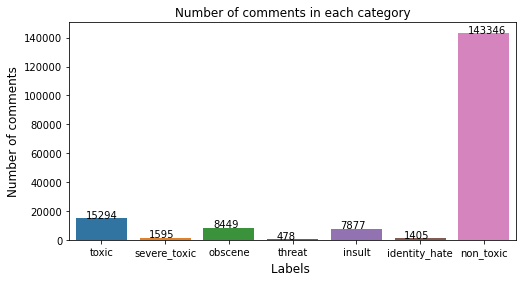

In [23]:
# Plot the number of labels in each categoty as a bar plot to have a better idea
plt.figure(figsize=(8,4))
sn.barplot(category_count.index,category_count.values)

plt.title("Number of comments in each category")
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Labels ', fontsize=12)

counts=category_count.values
xlocs,xlab=plt.xticks()
for i,value in enumerate(counts):
    plt.text(xlocs[i] - 0.25,value,str(value))

From the above plot it is clear that non_toxic comments have more samples compared to other labels. So to decrease the processing time we are taking only 20000 non_toxic comments

In [10]:
data_non_tox=data[data['non_toxic']==1] # dataset with non_toxic comments only

In [11]:
data_non_tox= data_non_tox.iloc[:20000,:] # Selecting only 20000 non_toxic comments

In [12]:
data_non_tox.head(10) # display first 10 non toxic comment data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0,1
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0,1
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0,1
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0,1
10,0005300084f90edc,"""\nFair use rationale for Image:Wonju.jpg\n\nT...",0,0,0,0,0,0,1


##### create a new data frame with only 20000 nontoxic data and all other data in the same amount

In [13]:
# Insert all non_toxic comments to the new data frame
data_new = data[data['non_toxic']==0]

In [14]:
# add 20000 non_toxic comments to the data frame
data_new = pd.concat([data_new,data_non_tox])
data_new = data_new.sample(frac=1) #Shuffle the data in the dataframe

In [15]:
data_new.head(20) #Display first 20 rows of the new data

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
1841,04fafc93955fdd1b,"View Askew \nyou are right, they should go OR ...",0,0,0,0,0,0,1
62623,a78fb12530c91a63,"you have a message re your last change, go fuc...",1,0,1,0,1,0,0
14836,27384ae57cb921ff,"Hello, , and welcome to Wikipedia! Thank you f...",0,0,0,0,0,0,1
144369,0c015256550e2ff3,First Off\n\nAvril Lavagflaps is a suck ass si...,1,0,1,0,1,0,0
15918,2a0209e2622fd4b7,"""\n\nI see your point, thanks for making it cl...",0,0,0,0,0,0,1
69472,b9d0e59c6a2a6e1f,the jungle baby your guna die!,1,0,0,0,0,0,0
2366,065b10e83e654132,User:NHRHS2010 is a homo like mitt romney is. ...,1,0,1,0,1,1,0
7313,13705d3b5fc86258,"""\n\nRandalmann, just look at the title. """"Dub...",0,0,0,0,0,0,1
48492,81a67be17dd78fe7,hi please unblock me you cunt i want to tell ...,1,0,1,0,0,0,0
18562,30f9b4bc46f0c38e,"""\nI just came to this article for the first t...",0,0,0,0,0,0,1


From the above data we can see that index of the data has been changed because we removed non_toxic data from the orginal data. So we  will be resetting the index 

In [16]:
# reset index and display first few rows in the data frame
data_new.reset_index(drop=True, inplace=True)
data_new.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,non_toxic
0,04fafc93955fdd1b,"View Askew \nyou are right, they should go OR ...",0,0,0,0,0,0,1
1,a78fb12530c91a63,"you have a message re your last change, go fuc...",1,0,1,0,1,0,0
2,27384ae57cb921ff,"Hello, , and welcome to Wikipedia! Thank you f...",0,0,0,0,0,0,1
3,0c015256550e2ff3,First Off\n\nAvril Lavagflaps is a suck ass si...,1,0,1,0,1,0,0
4,2a0209e2622fd4b7,"""\n\nI see your point, thanks for making it cl...",0,0,0,0,0,0,1
5,b9d0e59c6a2a6e1f,the jungle baby your guna die!,1,0,0,0,0,0,0
6,065b10e83e654132,User:NHRHS2010 is a homo like mitt romney is. ...,1,0,1,0,1,1,0
7,13705d3b5fc86258,"""\n\nRandalmann, just look at the title. """"Dub...",0,0,0,0,0,0,1
8,81a67be17dd78fe7,hi please unblock me you cunt i want to tell ...,1,0,1,0,0,0,0
9,30f9b4bc46f0c38e,"""\nI just came to this article for the first t...",0,0,0,0,0,0,1


##### Plot count of data in each label after removing some of the non_toxic data 

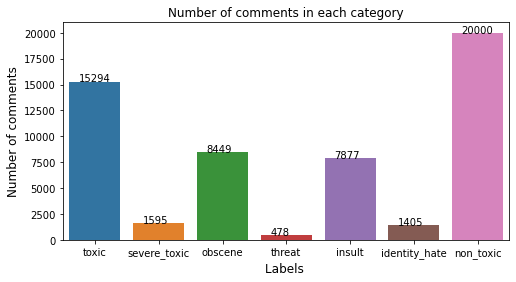

In [17]:
# Checking counts of comments in each category for the new data frame created
category_count=data_new.iloc[:,2:].sum()
# Plot the number of labels in each categoty as a bar plot to have a better idea
plt.figure(figsize=(8,4))
sn.barplot(category_count.index,category_count.values)

plt.title("Number of comments in each category")
plt.ylabel('Number of comments', fontsize=12)
plt.xlabel('Labels ', fontsize=12)

counts=category_count.values
xlocs,xlab=plt.xticks()
for i,value in enumerate(counts):
    plt.text(xlocs[i] - 0.25,value,str(value))

In [18]:
# Assign the dependent variable column names to an array
labels = ['toxic','severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

#### Word Cloud Visualisation

WordCloud visualisation helps us to find most frequent words in a particular label. This will help us to give an idea of important words that are present each labels

In [34]:
def word_cloud_visualisation(data,label):
    data_sub = data[data[label]==1]
    comment_txt = data_sub.comment_text.values
    wc = WordCloud(background_color="black",max_words=3000)
    
    wc.generate(" ".join(comment_txt))
    plt.figure(figsize=(20,20))
    plt.subplot(221)
    plt.axis("off")
    plt.title("Words frequented in {}".format(label), fontsize=20)
    plt.imshow(wc.recolor(colormap= 'Blues' , random_state=244), alpha=0.98)

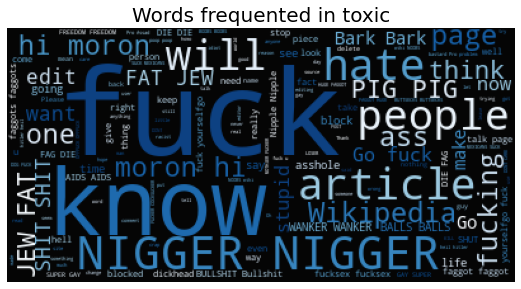

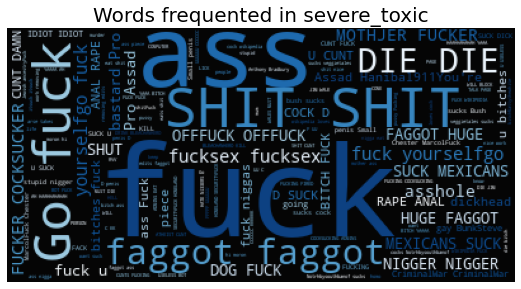

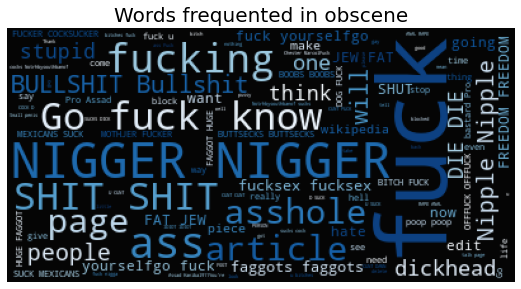

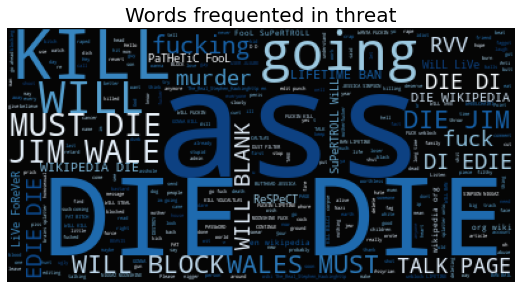

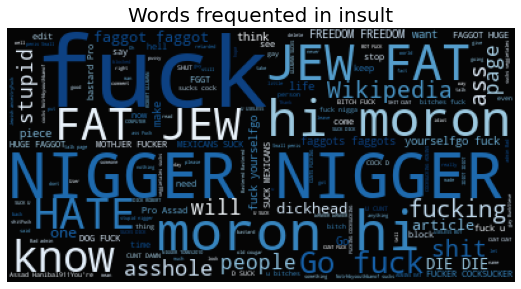

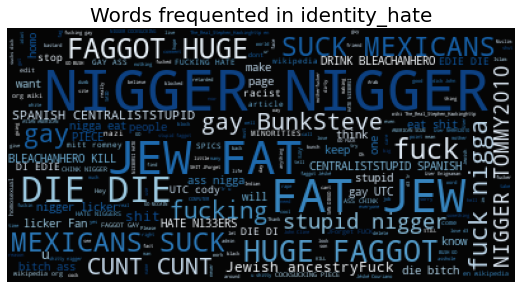

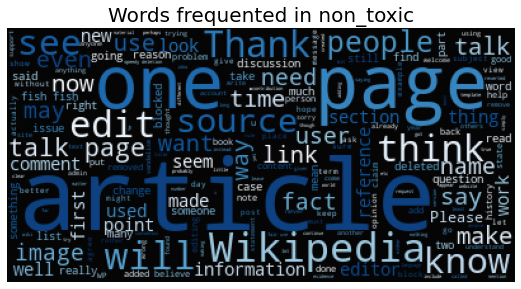

In [44]:
# Invoke the word cloud visualisation function for each label  in the dataset
for label in data_new.columns[2:]:
    word_cloud_visualisation(data_new,label)

## Experiment Setup - 1 

#### Objective

In our first setup we will be experimenting on one of the preprocessing method to change the words in different form to a base form.
Different methods use in this process is 
 1. Stemming using PorterStemmer fucntion
 2. Lemmatisation using WordNetLemmatizer

We will create two dataset each method. Vectorisation, Modeling and performance evaluation will be done for each of the dataset and best performed method will be selected for later experiments.

##### Pre-observations

Before removing the extra non_toxic comments when I tried to stem or lemmatise the data the processing time taken was very big and that too ended up with recursion error, memory allocation error etc. This observation was shared among the group members and decided to decrease the total data count according to the loic of each individual

###### Preprocess Dataset 
Input dataset will be undergoing some prerprocessing to get a perfect model with maximum performance.

Following steps will be done to make preprocess the dependent variable (comment_text)

 1. Replace newline, carriage return, tabs and digits with white spaces
 2. Convert all the comments to lower case
 3. Split the comments into words
 4. Apply stemming or Lemmatisation to each words and remove stop words from the sentence.
 5. After applying this words are joined and attached to the same data frame
 6. Stemmed dataset and Lemmatised datasets will kept in different variable to evaluate them separately 


In [19]:

# Remove unnecessary characters, stopwords and then apply stemming to each words in the comment_text column of the data
lem = WordNetLemmatizer()
data_lem = data_new.copy() #Create a copy of the initial dataset for lematisation
ps = PorterStemmer()
for i in range(0, len(data_new)):
    regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    comments= regex.sub(" ", data_new['comment_text'][i])# replacing digits carrige returns, tabs and newline with blank space
    comments = comments.lower()
    comments = comments.split()
    comments1 = [ps.stem(word) for word in comments if not word in stopwords.words('english')]
    #comments2 = [lem.lemmatize(word) for word in comments if not word in stopwords.words('english')]
    # save stemmed values to first dataset
    data_new['comment_text'][i] = ' '.join(comments1)
    # save lemmatised values to second dataset
    #data_lem['comment_text'][i] =  ' '.join(comments2)
   

Before removing the extra non_toxic comments when we tried to stem the data the processing time taken was very big and that too ended up with recursion error, memory allocation error etc.

In [53]:
data_lem.loc[0:20,'comment_text'] # Display lemmatised comment_text values for reference

0     another fine point multiple editor keep beatin...
1                                  user abd muslim scum
2     proposed change usc say united state statute l...
3     edinburgh one europe main financial center edi...
4     proposition article overwhelmed image socialis...
5     ok peer viewed month published academic archiv...
6     pole smoker suck cock —preceding unsigned comm...
7     know real difficulty little prick learn taking...
8     remade temlate eastern slav broken anon see ta...
9                            stupid stupid anyone agree
10    funny would say exactly thing astarti anonymou...
11    wow one commenting user commenting page drooli...
12    hi howcheng honoured happy hear recent article...
13                                     okay apology del
14    hate grandma terri hate step grandma grandma t...
15    epic fail freaking serious cannot blocked fail...
16    btw love harrass try banning year stop wish zh...
17    stupid page please expand article make big

In [55]:
data_new.loc[0:20,'comment_text']  # Display some of the Stemmed comment_text values for reference

0     anoth fine point multipl editor keep beat hors...
1                                  user abd muslim scum
2     propos chang usc say unit state statut larg sh...
3     edinburgh one europ main financi center edinbu...
4     proposit articl overwhelm imag socialist emble...
5     ok peer view month publish academ archiv line ...
6       pole smoker suck cock —preced unsign comment ad
7     know real difficulti littl prick learn take pr...
8     remad temlat eastern slav broken anon see talk...
9                              stupid stupid anyon agre
10    funni would say exactli thing astarti anonym u...
11    wow one comment user comment page drool retard...
12    hi howcheng honour happi hear recent articl go...
13                                      okay apolog del
14    hate grandma terri hate step grandma grandma t...
15      epic fail freak seriou cannot block fail goodby
16    btw love harrass tri ban year stop wish zhanzh...
17    stupid page pleas expand articl make big a

We can see that all the comments are converted to lower case and stemming has been applied to each words

### Feature Engineering

In this method we will be doing process to convert our data to a state that is ready to be applied to the model for that we will be following the below steps :

1. Split the dataset using train test split method
2. Convert the train data and test data to vectors which can be used to train and test the model ( We are using Bag of Words      technique using CountVectoriser with unigrams to for vectorisation)
3. Display and observe the features that has been used by CountVectoriser to create vectors.
4. All the steps have to be done for both datasets data_new(stemmed) and data_lem(lemmatised) to analyse the output

In [20]:
# Initialize vectorizer to a variable with ngram range feature as (1,1)(Unigram)

cvec = CountVectorizer(ngram_range=(1,1))
cvec_1 = CountVectorizer(ngram_range=(1,1))

Train and test splitting is done on both the dataset with test size as 30 percentage and shuffle as true . Random state is set to 42 to get the same shuffling output each time

In [21]:
# train test split for stemmed dataset
train, test = train_test_split(data_new, test_size=0.30, random_state=42, shuffle=True)

#train test split for lemmatised dataset
train_1, test_1 = train_test_split(data_lem, test_size=0.30, random_state=42, shuffle=True)

In [22]:
# Size of the train and test data for stemmed dataset
print("Size of the training data for stemmed data :" ,train.shape)
print("Size of the testing data for stemmed data :" ,test.shape)

Size of the training data for stemmed data : (25357, 9)
Size of the testing data for stemmed data : (10868, 9)


In [39]:
# Size of the train and test data for lemmatised dataset
print("Size of the training data for lemmatised data :" ,train_1.shape)
print("Size of the testing data for lemmatised data :" ,test_1.shape)

Size of the training data for lemmatised data : (25357, 9)
Size of the testing data for lemmatised data : (10868, 9)


Comment_text columnn of the train and test dataset will be vectorised to make it suitable for modelling

In [24]:
X_train = train['comment_text'] # independent variable of train data
X_test = test['comment_text']  # independent variable of test data

X_train_1 = train_1['comment_text'] 
X_test_1 = test_1['comment_text']

In [25]:
# Vectorize training comments for first dataset
X_train_vec= cvec.fit_transform(X_train)

In [26]:
# Vectorize testing comments for first dataset
X_test_vec=cvec.transform(X_test)

In [43]:
# Vectorize training comments for Second dataset
X_train_vec_1 = cvec_1.fit_transform(X_train_1)

In [44]:
# Vectorize training comments for Second dataset
X_test_vec_1 = cvec_1.transform(X_test_1)

In [28]:
# We can analyze some of the features used to vectorize the comments in the data
cvec.get_feature_names()

['aa',
 'aaa',
 'aaaa',
 'aaaaa',
 'aaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaani',
 'aaaaaaaaaah',
 'aaaannnnyyyywwwwhhhheeeerrrreee',
 'aaaawwww',
 'aaaboyz',
 'aaai',
 'aaarrrgggh',
 'aab',
 'aac',
 'aachen',
 'aachi',
 'aademia',
 'aadil',
 'aagadu',
 'aagin',
 'aah',
 'aahoa',
 'aak',
 'aalertbot',
 'aaliyah',
 'aand',
 'aaot',
 'aap',
 'aarab',
 'aarau',
 'aardvark',
 'aarem',
 'aarn',
 'aaron',
 'aarp',
 'aaryanrajput',
 'aat',
 'ab',
 'aback',
 'abad',
 'aban',
 'abandon',
 'abantecart',
 'abb',
 'abba',
 'abbey',
 'abbott',
 'abbrevi',
 'abbus',
 'abbythecat',
 'abc',
 'abd',
 'abdel',
 'abdic',
 'abdin',
 'abdomen',
 'abduct',
 'abdul',
 'abdulkadir',
 'abdulla',
 'abdullah',
 'abdur',
 'abe',
 'abecedar',
 'abeg',
 'abercrombi',
 'abernathi',
 'aberr',
 'abet',
 'abf',
 'abhay',
 'abhi',
 'abhishek',
 'abhorr',
 'abhramid',
 'abi',
 'abian',
 'abid',
 'abigail',
 'abil',
 'abilit',
 'abingdon',
 'abiogen',
 'abit',
 'abject',
 'abkaz',
 'abkazia',


In [46]:
# Features of the lemmatised dataset used for vectorisation
cvec_1.get_feature_names()[120:140]

['abortionref',
 'abosolut',
 'abosolute',
 'abot',
 'abotu',
 'abound',
 'abounds',
 'abour',
 'about',
 'abouthosur',
 'abouts',
 'aboutself',
 'aboutus',
 'aboutv',
 'aboveboard',
 'abp',
 'abpout',
 'abraham',
 'abrahamic',
 'abrahamsson']

### Modeling and Evaluation

Next step in our process is to train the vectors created for train and test data of both the dataset using a particular model and then Evaluate the result by using test data.

Steps include:

1. Initialize the model - Random Forest Classifier
2. Define a function to visualise the confusion matrix produced
3. Train the Random Forest Classifier model using our preprocessed datas 
4. Evaluate the model output using various parameters like Accuracy, F1 score , Confusion Matrix

In [173]:
#initialize random forest models for two datasets
rf = RandomForestClassifier(n_estimators=200,criterion='entropy') 
rf_1 = RandomForestClassifier(n_estimators=200,criterion='entropy') 

Now we can create a function to plot the confusion matrix

In [174]:
def plot_conf(cm,label):
    """
    Plot Confusion matrix of input cm.
    """
    cm = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    ax = plt.axes()
    sns.heatmap(cm,
                annot=True,
                annot_kws={"size": 12},
                cmap="Blues",
                fmt='.2f',
                linewidths=1,
                linecolor='steelblue',
                xticklabels=("Non-toxic", label),
                yticklabels=("Non-toxic", label))

    plt.ylabel('True', fontsize=18)
    plt.xlabel('Predicted', fontsize=18)
    plt.title('Confusion Matrix for '+label,fontsize=20)
    plt.show()

In [175]:
# Function to train the model test the model and evaluate the model using confusion matrix

def model_scoring(model,X_train,X_test,test,train,label):
    model.fit(X_train,train[label])
    predictions = model.predict(X_test)
    conf_matrix = confusion_matrix(test[label],predictions)
    
    # Plot the confusion matrix for better understanding
    plot_conf(conf_matrix,label)
   
    #create a list for various scores of the prediction 
    scores = { 'Accuracy Score' : [accuracy_score(test[label],predictions)],'Recall Score':[recall_score(test[label],predictions)],
              'Precision Score' : [precision_score(test[label],predictions)],'F1 Score' : [f1_score(test[label],predictions)]}
    
    # create a data frame with different scoring as column names
    scoring_data = pd.DataFrame(scores, index=[label])
    return(scoring_data)
    

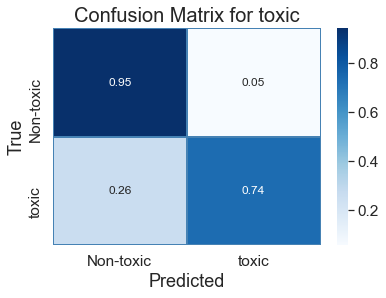

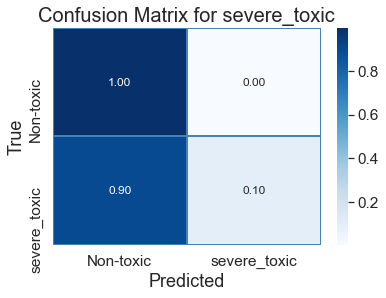

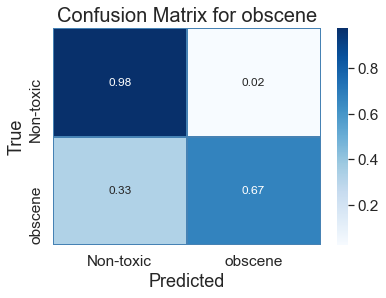

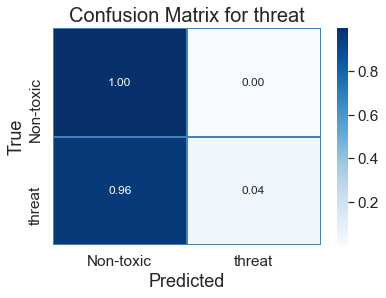

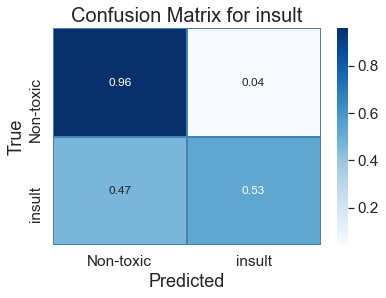

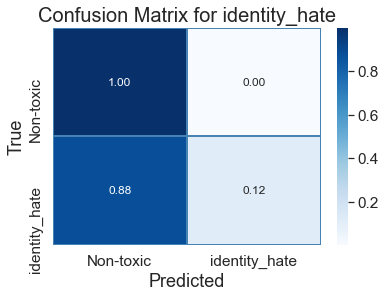

,Accuracy Score,Recall Score,Precision Score,F1 Score
toxic,0.858760,0.738522,0.908797,0.814859
severe_toxic,0.955374,0.104082,0.525773,0.173765
obscene,0.905502,0.671701,0.893707,0.766962
threat,0.986842,0.041667,0.545455,0.077419
insult,0.869709,0.534671,0.778413,0.633919
identity_hate,0.965127,0.116788,0.750000,0.202105


In [176]:
data_scor_final = pd.DataFrame()
for label in labels:
    data_scoring = model_scoring(rf,X_train_vec,X_test_vec,test,train,label)
    data_scor_final = pd.concat([data_scor_final,data_scoring])
    
display(data_scor_final)

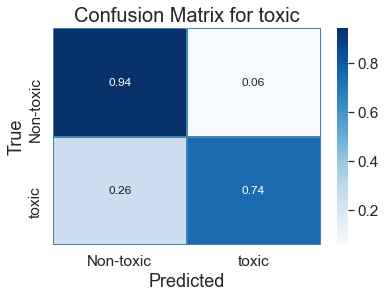

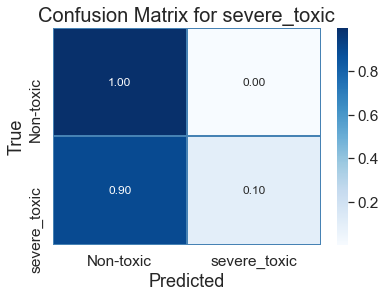

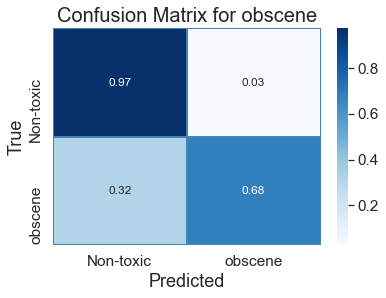

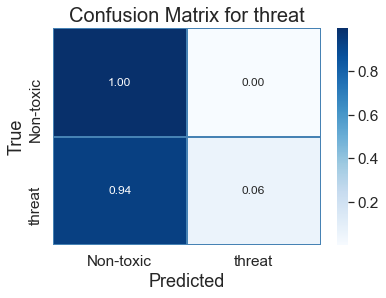

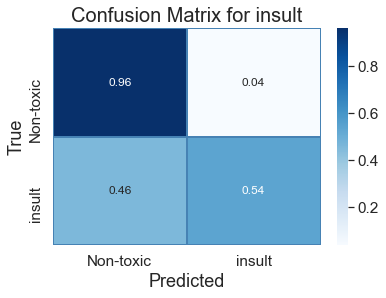

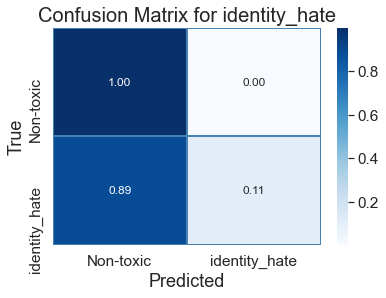

,Accuracy Score,Recall Score,Precision Score,F1 Score
toxic,0.858760,0.741801,0.905524,0.815527
severe_toxic,0.956110,0.104082,0.573034,0.176166
obscene,0.905226,0.678855,0.884974,0.768331
threat,0.987118,0.062500,0.642857,0.113924
insult,0.872378,0.542521,0.786346,0.642065
identity_hate,0.964943,0.107056,0.758621,0.187633


In [177]:
# Now run modeling and evaluation for our second dataset that is the dataset with lemmatised data

data_scor_final_1 = pd.DataFrame()
for label in labels:
    data_scoring_1 = model_scoring(rf_1,X_train_vec_1,X_test_vec_1,test_1,train_1,label)
    data_scor_final_1 = pd.concat([data_scor_final_1,data_scoring_1])
    
display(data_scor_final_1)

In [294]:
# Compare the F1_Score of both modeling in a dataframe
df_comp_score = pd.concat([data_scor_final['F1 Score'],data_scor_final_1['F1 Score']],axis=1,keys=["F1 score (stemming)","F1 score (lemmatising)"])
display(df_comp_score)

,F1 score (stemming),F1 score (lemmatising)
toxic,0.814859,0.815527
severe_toxic,0.173765,0.176166
obscene,0.766962,0.768331
threat,0.077419,0.113924
insult,0.633919,0.642065
identity_hate,0.202105,0.187633


Text(0.5, 1.0, 'F1 Score for Lemmatisation and stemming')

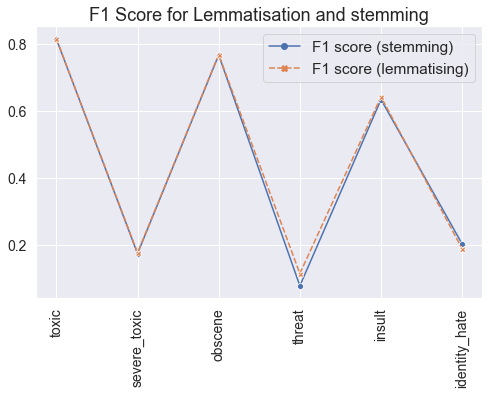

In [295]:
# Plot the comparison in a line graph for better understanding
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_comp_score, markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score for Lemmatisation and stemming', fontsize=18)

### Conclusion

* From the observartions we can see that there is no much difference in the output if we use lemmatisation or stemming.So we can conclude that using any of the method for further experimentation is fine. I have decided to use stemmed data (data_new) for my further experimentation. 

* We can observe another important analysis from the above results. For each category we can see that F1 score of True case(for 1) is very less. This is because we have more non_toxic comments than toxic comment for each category of toxicity. This is the imbalance issue in our dataset.

We have the number of comments in each category as,

    1) toxic            15294
    2) severe_toxic      1595
    3) obscene           8449
    4) threat             478
    5) insult            7877
    6) identity_hate     1405

To balance the 0 and 1 datas to be balanced we are taking a min ratio of 20 percentage for each state. For this we will divide our dataset 'data_new' to 6 dataframes, one for each category. This logic was decided among the group and 3 of us will be doing the same approach.

### Manipulating Dataset to Overcome Class Imbalance Issue

In this experiment we will try to balance the dataset by maintaining a ratio of atleat 20-80 percentage between true label and false label so that we will overcome the class imbalance issue.

Steps involved are:
* Split the dataset in to 6 categories 1 for each label
* Balance each of these data set by adding 0 and 1 in atleat 80:20 ratio
* Model the data and analyse the performance

### Dataset Creation

##### 1) Splitting entire dataset in to 6 set one for each label

In [194]:
# Creating different datasets for each category

toxic_data = data_new.loc[:,['id','comment_text','toxic']]

severe_toxic_data = data_new.loc[:,['id','comment_text','severe_toxic']]

obscene_data = data_new.loc[:,['id','comment_text','obscene']]

threat_data = data_new.loc[:,['id','comment_text','threat']]

insult_data = data_new.loc[:,['id','comment_text','insult']]

hate_data = data_new.loc[:,['id','comment_text','identity_hate']]

#### 2) Balancing 0 and 1 data of each data with atleast 20-80 ratio

### Toxic
For toxic data we have 15000+ data for 1 so we take 5000 data each for 0 and 1

In [195]:
# Take 5000 rows for 0 and 1 cases and print the shape
toxic_data_0 = toxic_data[toxic_data['toxic'] == 0].iloc[0:5000,:]
toxic_data_0.shape

toxic_data_1 = toxic_data[toxic_data['toxic'] == 1].iloc[0:5000,:]
toxic_data_1.shape

(5000, 3)

In [196]:
toxic_data_1.shape

(5000, 3)

In [197]:
# concatinate the two datasets to get the final dataset for toxic comments

toxic_data_final = pd.concat([toxic_data_0,toxic_data_1],axis=0)

toxic_data_final.reset_index(drop=True, inplace=True) # Reset index

toxic_data_final.shape

(10000, 3)

In [198]:
toxic_data_final

,id,comment_text,toxic
0,3a7b232cd4d4a031,anoth fine point multipl editor keep beat hors...,0
1,11840aa4eb2a739a,propos chang usc say unit state statut larg sh...,0
2,2858042cc2ee5321,edinburgh one europ main financi center edinbu...,0
3,3a2ac1fc5ceb9f39,proposit articl overwhelm imag socialist emble...,0
4,00ef2984561935dc,ok peer view month publish academ archiv line ...,0
...,...,...,...
9995,a8e132588240f6b1,big ass warn type thing step user page reserv ...,1
9996,0e57255bedea8884,fat disgust freak destin live long pathet lone...,1
9997,b1caf669666bf4bb,heil hitler white power god bitch pussi tasti,1
9998,bb1138ab713f89d1,real life fat dirti slob asian,1


### Severe Toxic
For severe toxic we have 1595 samples so we can do the same method

In [199]:
# Take 1595 rows for 0 and 1 cases and print the shape
severe_toxic_data_0 = severe_toxic_data[severe_toxic_data['severe_toxic'] == 0].iloc[0:1595,:]
severe_toxic_data_0.shape

severe_toxic_data_1 = severe_toxic_data[severe_toxic_data['severe_toxic'] == 1].iloc[0:1595,:]
severe_toxic_data_1.shape

(1595, 3)

In [200]:
# concatinate the two datasets to get the final dataset for severe toxic comments

severe_toxic_data_final = pd.concat([severe_toxic_data_0,severe_toxic_data_1],axis=0)

severe_toxic_data_final.reset_index(drop=True, inplace=True) # Reset index

severe_toxic_data_final.shape

(3190, 3)

### Obscene

For obscene we have 8449 data so we will ake 5000 each

In [201]:
# Take 5000 rows for 0 and 1 cases and print the shape
obscene_data_0 = obscene_data[obscene_data['obscene'] == 0].iloc[0:5000,:]
obscene_data_0.shape

obscene_data_1 = obscene_data[obscene_data['obscene'] == 1].iloc[0:5000,:]
obscene_data_1.shape

(5000, 3)

In [202]:
# concatinate the two datasets to get the final dataset for obscene comments

obscene_data_final = pd.concat([obscene_data_0,obscene_data_1],axis=0)

obscene_data_final.reset_index(drop=True, inplace=True) # Reset index

obscene_data_final.shape

(10000, 3)

### Threat

For threat we have only 478 data so we will take atmost 80 percentage of the clean data else the dataset will be very small

In [203]:
# Take 1700 rows for 0 and 478 for 1 cases and print the shape
threat_data_0 = threat_data[threat_data['threat'] == 0].iloc[0:1700,:]
threat_data_0.shape

threat_data_1 = threat_data[threat_data['threat'] == 1].iloc[0:478,:]
threat_data_1.shape

(478, 3)

In [204]:
# concatinate the two datasets to get the final dataset for threat comments

threat_data_final = pd.concat([threat_data_0,threat_data_1],axis=0)

threat_data_final.reset_index(drop=True, inplace=True) # Reset index

threat_data_final.shape

(2178, 3)

In [205]:
threat_data_final

,id,comment_text,threat
0,3a7b232cd4d4a031,anoth fine point multipl editor keep beat hors...,0
1,bf3e08b8be31f02d,user abd muslim scum,0
2,11840aa4eb2a739a,propos chang usc say unit state statut larg sh...,0
3,2858042cc2ee5321,edinburgh one europ main financi center edinbu...,0
4,3a2ac1fc5ceb9f39,proposit articl overwhelm imag socialist emble...,0
...,...,...,...
2173,6e9826f166b7d7fe,nazi like deserv wors death make sure suffer h...,1
2174,77d84b1321c22d9a,lgbt littl fuck fag piec shit page make fuck c...,1
2175,db7088509704e2da,hell hell fuck problem go sue fuck pant dicrim...,1
2176,ceec9ca7cb20b5da,go report son wait mind give donkey punch say ...,1


### Insult

We have only 7877 insult comments so we will take 5000 each 

In [206]:
# Take 5000 rows for 0 and 1 cases and print the shape
insult_data_0 = insult_data[insult_data['insult'] == 0].iloc[0:5000,:]
insult_data_0.shape

insult_data_1 = insult_data[insult_data['insult'] == 1].iloc[0:5000,:]
insult_data_1.shape

(5000, 3)

In [207]:
# concatinate the two datasets to get the final dataset for insult comments

insult_data_final = pd.concat([insult_data_0,insult_data_1],axis=0)

insult_data_final.reset_index(drop=True, inplace=True) # Reset index

insult_data_final.shape

(10000, 3)

### Identity Hate

We have only 1405 comments for Identity Hate so we will do the same method as threat to make the class balanced

In [208]:
# Take 5000 rows for 0 and 1405 data for 1 and print the shape
hate_data_0 = hate_data[hate_data['identity_hate'] == 0].iloc[0:5000,:]
hate_data_0.shape

hate_data_1 = hate_data[hate_data['identity_hate'] == 1].iloc[0:1405,:]
hate_data_1.shape

(1405, 3)

In [209]:
# concatinate the two datasets to get the final dataset for insult comments

hate_data_final = pd.concat([hate_data_0,hate_data_1],axis=0)

hate_data_final.reset_index(drop=True, inplace=True) # Reset index

hate_data_final.shape

(6405, 3)

We can add all these dataframe to a list so that we can process them easiy

In [210]:
# Combining all dataframes to a list
data_final=[toxic_data_final,severe_toxic_data_final,obscene_data_final,threat_data_final,insult_data_final,hate_data_final]

#### So these data sets will be used for all our experiments from now on to get better output

### Modelling and Evaluation

A function is created to split the data, vectorise the data, model the data and analyse the performance of the model 

In [211]:
def split_vec(data,ngram,test_size,model,label):
    cvec = CountVectorizer(ngram_range=(ngram))
    train_data, test_data = train_test_split(data, test_size=test_size, random_state=42, shuffle=True)
    X_train = train_data['comment_text'] # independent variable of train data
    X_test = test_data['comment_text']  # independent variable of test data
    # Vectorize training comments
    X_train_vec= cvec.fit_transform(X_train)
    X_test_vec = cvec.transform(X_test)
    score_data=model_scoring(model,X_train_vec,X_test_vec,test_data,train_data,label)
    return(score_data)

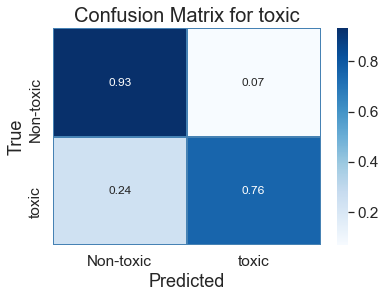

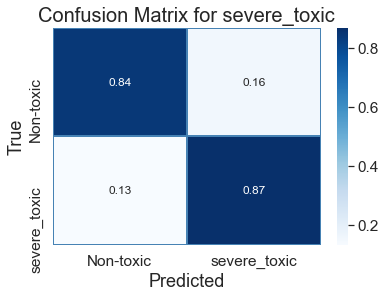

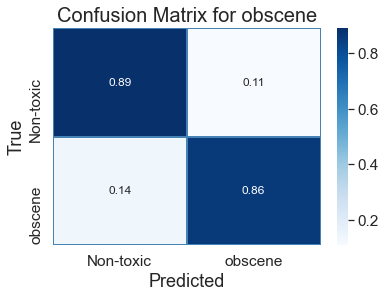

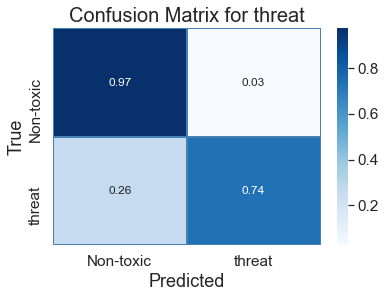

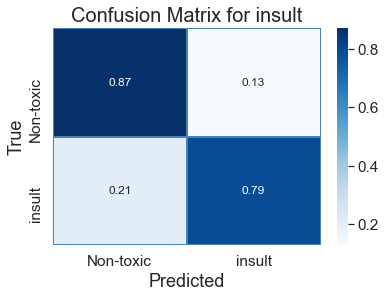

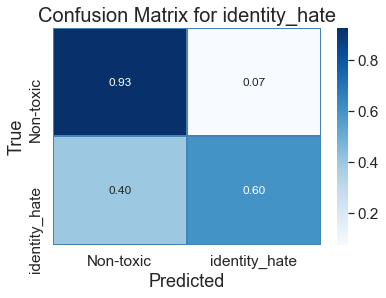

,Accuracy Score,Recall Score,Precision Score,F1 Score
toxic,0.846667,0.755297,0.915493,0.827715
severe_toxic,0.854754,0.867647,0.844581,0.855959
obscene,0.875000,0.859193,0.881487,0.870197
threat,0.918960,0.735099,0.895161,0.807273
insult,0.834667,0.793575,0.856827,0.823989
identity_hate,0.859001,0.601467,0.694915,0.644823


In [212]:
data_scor_final_2= pd.DataFrame()
for data in data_final:
    data_scor_2=split_vec(data,(1,1),0.30,rf,data.columns.values[2])
    data_scor_final_2=pd.concat([data_scor_final_2,data_scor_2])
    
display(data_scor_final_2)

In [291]:
# Compare the F1_Score before and after solving class imbalance issue
df_comp_score = pd.concat([data_scor_final['F1 Score'],data_scor_final_2['F1 Score']],axis=1,keys=["F1 score ( With Class Imbalance Issue)","F1 score (Without Class Imbalance Issue)"])
display(df_comp_score)

,F1 score ( With Class Imbalance Issue),F1 score (Without Class Imbalance Issue)
toxic,0.814859,0.827715
severe_toxic,0.173765,0.855959
obscene,0.766962,0.870197
threat,0.077419,0.807273
insult,0.633919,0.823989
identity_hate,0.202105,0.644823


Text(0.5, 1.0, 'F1 Score With and Without Class Imabalance Issue ')

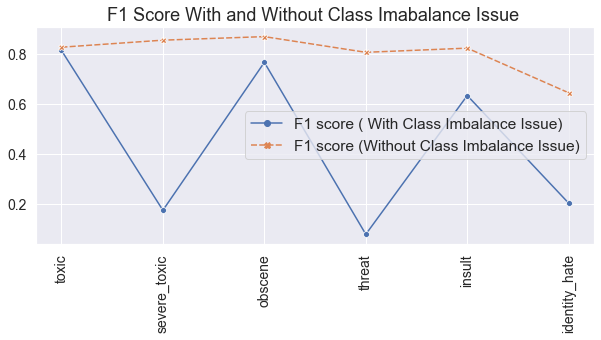

In [292]:
# Plot the comparison in a line graph for better understanding
plt.figure(figsize=(10, 4))
sns.lineplot(data=df_comp_score, markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score With and Without Class Imabalance Issue ', fontsize=18)

**Analysing the result after solving class imbalance issue we can see that there is a considerable increase in the F1 score of the model.**

## Experiment  Setup - 2

#### Objective

In our second experimentation setup we will be experimenting with two options of our modelling. First one is train and split methods and second one is by changing the parameters of the vectorisation technique(CountVectoriser).

Steps involved are:

       1). Check output by changing the test and train data set splitting method.  
           *  By using stratified method split 
           *  By Changing ratio of split of train and test data.
       2). Change the parameters of the vectorizer and analyse the variation in the result.
           * Use different ngram in vectorisation
           * Change max feature parameter of the CounterVectoriser function


1. We can define a function to vectorise the data, train model and evaluate them using F1 Score and other parameters

In [216]:
# Define the function split the dataset to test and train , train, predict and visualise the output confusion matrix

def split_vec_model_2(data,vectoriser,train_data,test_data,model,label): 
    X_train = train_data['comment_text'] # independent variable of train data
    X_test = test_data['comment_text']  # independent variable of test data
    # Vectorize training comments
    X_train_vec= vectoriser.fit_transform(X_train)
    X_test_vec = vectoriser.transform(X_test)
    score_data=model_scoring(model,X_train_vec,X_test_vec,test_data,train_data,label)
    return(score_data)

* First setup can be trained using max_feature =2500, Ngram =(1,2)(both unigram and bigram) and stratified method will be used for test and train split

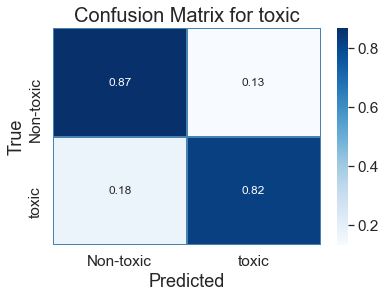

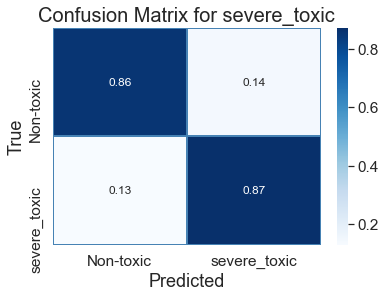

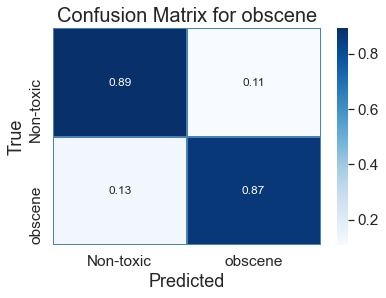

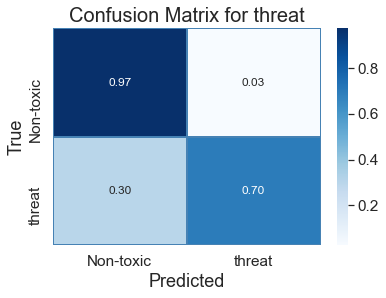

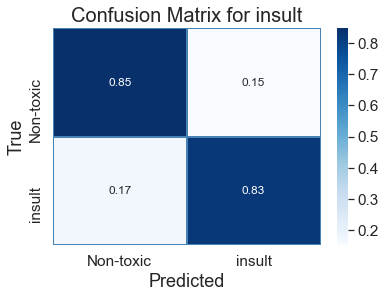

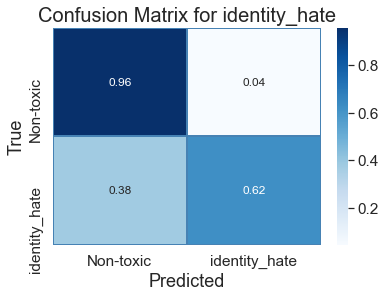

,Accuracy Score,Recall Score,Precision Score,F1 Score
toxic,0.845200,0.822400,0.861693,0.841588
severe_toxic,0.864662,0.872180,0.859259,0.865672
obscene,0.879600,0.866400,0.889893,0.877989
threat,0.913761,0.700000,0.884211,0.781395
insult,0.837600,0.826400,0.845336,0.835761
identity_hate,0.882022,0.621083,0.795620,0.697600


In [230]:
#define vectoriser with different ngram
#counter vectoriser with ngram as both unigram and bigram also max features has been limited to 2500
cv_exp2 = CountVectorizer(ngram_range=(1,2), max_features=2500) # Changing ngram and max feature parameter of the vectorizer

data_scor_exp2= pd.DataFrame()

for data in data_final:
    train_data, test_data = train_test_split(data, stratify=data[data.columns.values[2]],test_size=0.25) # data splitted in a stratified fashion
    data_scor = split_vec_model_2(data,cv_exp3,train_data,test_data,rf,data.columns.values[2])
    data_scor_exp2=pd.concat([data_scor_exp2,data_scor])
    
display(data_scor_exp2)



**Observation** - F1 Score has been increased


**Note** I have trained using max_feature =2500, Ngram =(2,2)(bigram alone) and stratified method will be used for test and train split with 30 percentage test data. But F1 score has been reduced so we are not using that combination of the data


In [224]:
# For reference of using (2,2)- bigram 

,Accuracy Score,Recall Score,Precision Score,F1 Score
toxic,0.660667,0.816667,0.622459,0.706459
severe_toxic,0.723093,0.564854,0.825688,0.670807
obscene,0.661333,0.466667,0.764192,0.579470
threat,0.834862,0.354167,0.772727,0.485714
insult,0.660667,0.492667,0.741968,0.592147
identity_hate,0.789282,0.274882,0.539535,0.364207


* Next we will try using Unigram(1,1) alone and increase the max_features to 3000

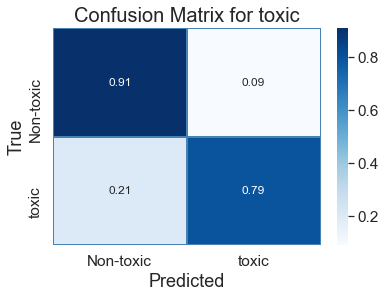

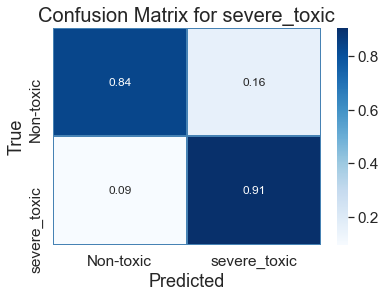

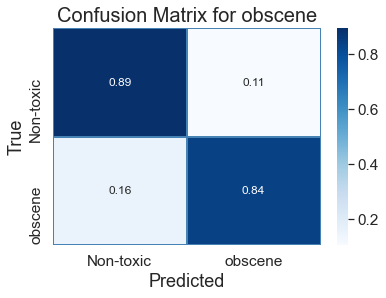

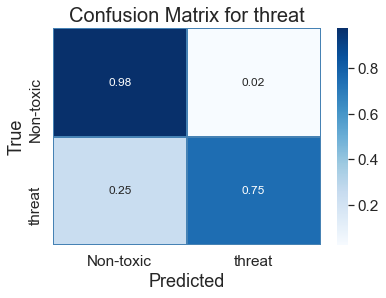

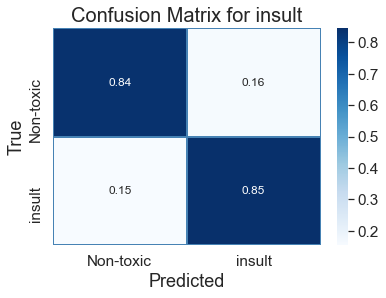

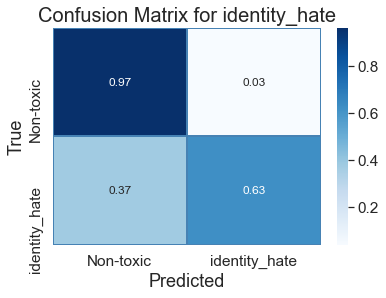

,Accuracy Score,Recall Score,Precision Score,F1 Score
toxic,0.851333,0.794000,0.896837,0.842291
severe_toxic,0.871473,0.906054,0.847656,0.875883
obscene,0.869333,0.844667,0.888499,0.866029
threat,0.926606,0.750000,0.900000,0.818182
insult,0.842667,0.846000,0.840397,0.843189
identity_hate,0.890739,0.625592,0.835443,0.715447


In [231]:
# use vectorizer with unigram alone 

cv_exp2_1 = CountVectorizer(ngram_range=(1,1), max_features=3000)

data_scor_exp2_1= pd.DataFrame()

for data in data_final:
    train_data, test_data = train_test_split(data, stratify=data[data.columns.values[2]],test_size=0.30)
    data_scor=split_vec_model_2(data,cv_exp2_1,train_data,test_data,rf,data.columns.values[2])
    data_scor_exp2_1=pd.concat([data_scor_exp2_1,data_scor])
    
display(data_scor_exp2_1)

**Observation -** F1 score and precision of the setup has been increased which means a greater a performance 

* Finally from the above results we can use (1,1) ngram , Max_feature = 3000 along with a different test train split that is split the data with 60:40 ratio

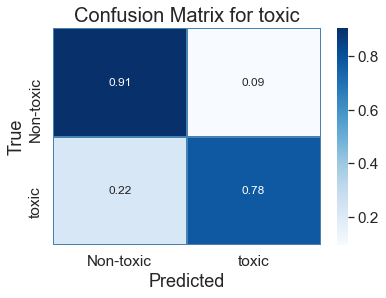

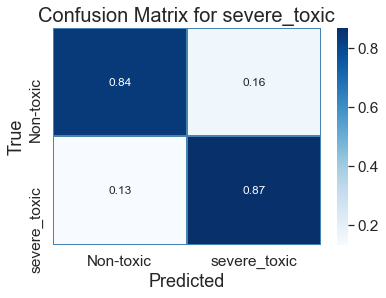

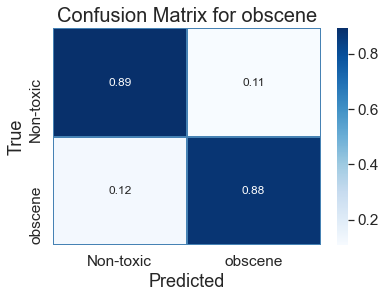

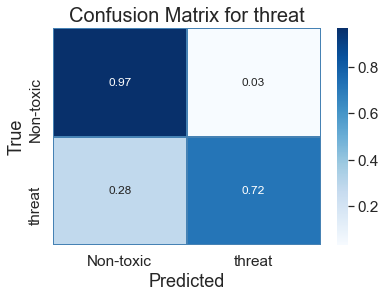

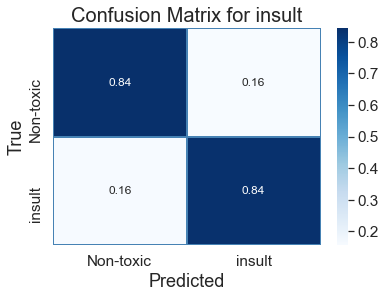

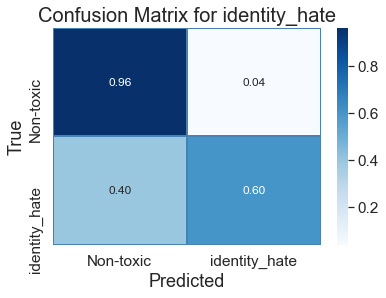

,Accuracy Score,Recall Score,Precision Score,F1 Score
toxic,0.844500,0.779094,0.886870,0.829496
severe_toxic,0.851881,0.867955,0.834365,0.850829
obscene,0.885000,0.876416,0.885536,0.880952
threat,0.915138,0.718750,0.873418,0.788571
insult,0.841750,0.839341,0.835469,0.837400
identity_hate,0.886807,0.603261,0.824257,0.696653


In [232]:
cv_exp2_2 = CountVectorizer(ngram_range=(1,1), max_features=3000)

data_scor_exp2_2= pd.DataFrame()

for data in data_final:
    train_data, test_data = train_test_split(data, test_size=0.40, random_state=42, shuffle=True)
    data_scor = split_vec_model_2(data,cv_exp2_2,train_data,test_data,rf,data.columns.values[2])
    data_scor_exp2_2=pd.concat([data_scor_exp2_2,data_scor])
    
display(data_scor_exp2_2)

**Final Observation

In [276]:
# Compare the F1_Score for 3 variations in exp setup2
df_comp_score = pd.concat([data_scor_exp2['F1 Score'],data_scor_exp2_1['F1 Score'],data_scor_exp2_2['F1 Score']],axis=1,keys=["F1 Score (Exp2.1 )","F1 Score (Exp2.2)","F1 Score (Exp2.3)"])
display(df_comp_score)

,F1 Score (Exp2.1 ),F1 Score (Exp2.2),F1 Score (Exp2.3)
toxic,0.841588,0.842291,0.829496
severe_toxic,0.865672,0.875883,0.850829
obscene,0.877989,0.866029,0.880952
threat,0.781395,0.818182,0.788571
insult,0.835761,0.843189,0.837400
identity_hate,0.697600,0.715447,0.696653


Text(0.5, 1.0, 'F1 Score for Different Test Split and CountVect Methods')

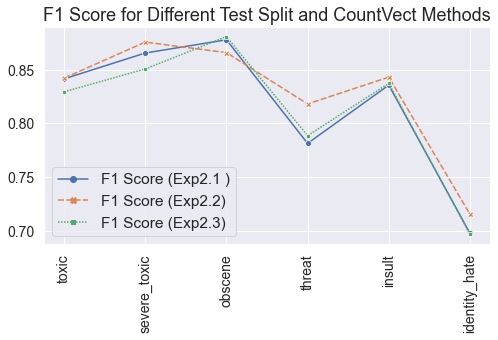

In [280]:
# Plot the comparison in a line graph for better understanding
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_comp_score, markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score for Different Test Split and CountVect Methods', fontsize=18)

### Conclusion

We have done 3 experiment with  combinations of test data split and Counter vectorisers to find the best one.

3 Combinations are :

1. ngram_range=(1,2), max_feature =2500, test_train_split = stratified
2. ngram_range=(2,2), max feature =2500, test_train_split = stratified
3. ngram_range=(1,1), max feature =3000, test_train_split = stratified 
4. ngram_range=(1,1), max feature =3000, test_train_split = 60:40 split 

Analysing the above combination we are getting the highest result for 3rd experiment that is for unigram, and stratified split with 3000 features. Least result is for the 2nd experiment with bigram alone and 2500 features.

We will be taking 3rd Combination for our final model

### Experiment Setup - 3

### Objective

In this experimentation setup I will be experimenting with one more vectoriser called TFIDF Vectoriser instead of CountVectoriser. Let us look into a quick definition of both vectorisers.

#### Vectorisation

Vectorisation is the method by which a collection of text is converted into vectors called feature vectors. Most popular feature extraction techniques used for vectorisation are CountVectorisation and TFID Vectorisation.

**1) CountVectoriser**
    
    CountVectoriser converts the text collection to a matrix that shows a representation of the occurence of text in collection
  
**2) TF-IDFVectoriser**

    Count matrix can be converted into a normalised form using Term Frequency(TF) or Term Frequency times Inverse Document Frequency(TF-IDF). Formula for tf-idf of a word t in a document d is stated as
    
                        tf-idf(t,d) = tf(t,d)*log(n/df(t)+1)

    tf(t,d) = Number of times the term occurs in the document
    n       = Number of documents in the collection 
    df(t)   = Number of documents in the collection that have the term t
           
    
    
    
Referenced from https://medium.com/@wenxuan0923/feature-extraction-from-text-using-countvectorizer-tfidfvectorizer-9f74f38f86cc

**1) In the first run we can use TF-IDF Vectoriser with unigram alone and 3500 as max_feature**

Note: I have run the same with different max_feature and ngram combination which resulted in lower efficiency  of the model

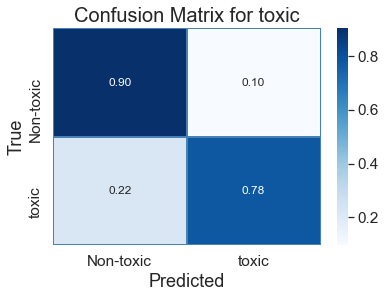

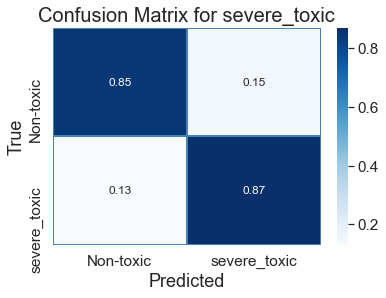

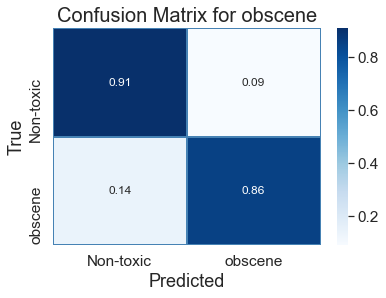

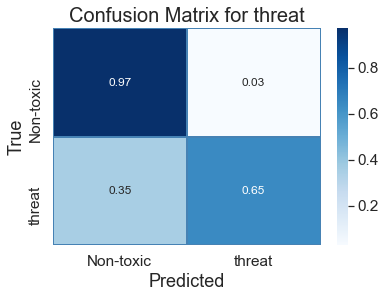

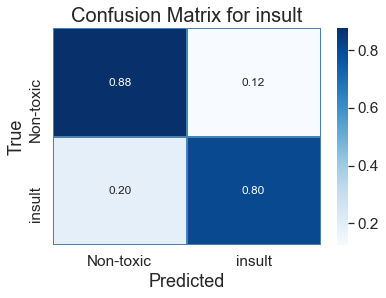

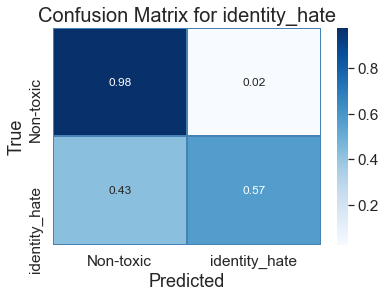

,Accuracy Score,Recall Score,Precision Score,F1 Score
toxic,0.841000,0.778667,0.889566,0.830430
severe_toxic,0.859979,0.870564,0.852761,0.861570
obscene,0.882333,0.855333,0.904158,0.879068
threat,0.900612,0.645833,0.869159,0.741036
insult,0.839000,0.802667,0.865564,0.832930
identity_hate,0.888658,0.573460,0.876812,0.693410


In [249]:
# use tf-idf vectoriser instead of Count Vectoriser

tfidf_exp3 = TfidfVectorizer(ngram_range=(1,1), max_features=3500)

data_scor_exp3= pd.DataFrame()

for data in data_final:
    train_data, test_data = train_test_split(data, stratify=data[data.columns.values[2]],test_size=0.30)
    data_scor=split_vec_model_2(data,tfidf_exp3,train_data,test_data,rf,data.columns.values[2])
    data_scor_exp3=pd.concat([data_scor_exp3,data_scor])
    
display(data_scor_exp3)

**Analyse some properties of vectoriser after applying to our data**

In [244]:
# Display the parameters used by tfidf for vectorisation
tfidf_exp3.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 3500,
 'min_df': 1,
 'ngram_range': (1, 1),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [245]:
 # Print the feature that are used to create vector usinf tfidf
tfidf_exp3.get_feature_names()[20:30]

['accur',
 'accuraci',
 'accus',
 'ace',
 'achiev',
 'acknowledg',
 'acousmat',
 'across',
 'act',
 'action']

In [256]:
# Display the weights of each feature after transformation using tfidf

# Create a dataframe with features in one column and its corresponfing idf weights in the other column
data_idf_weights = pd.DataFrame(tfidf_exp3.idf_, index=tfidf_exp3.get_feature_names(),columns=["idf_weights"]) 
 
# sort ascending and display the terms and its idf weights
data_idf_weights.sort_values(by=['idf_weights'])


,idf_weights
like,2.861485
articl,2.903983
page,2.913005
fuck,2.925163
wikipedia,2.998096
...,...
transgend,8.715124
carey,8.715124
meatspin,8.715124
pennni,8.715124


**2) For the second run we will change one more additional parameter max_df to .65 which is a threshold to select terms while creating vocabulary**

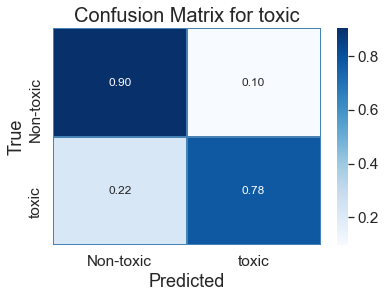

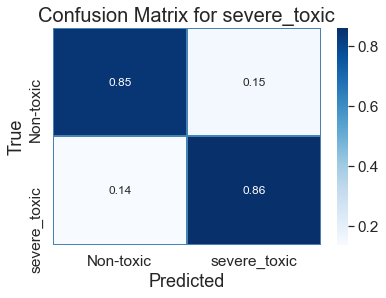

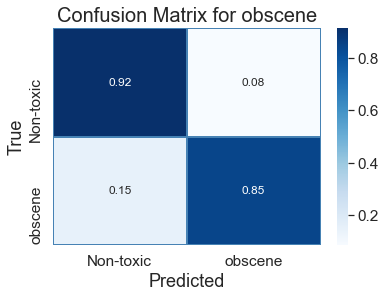

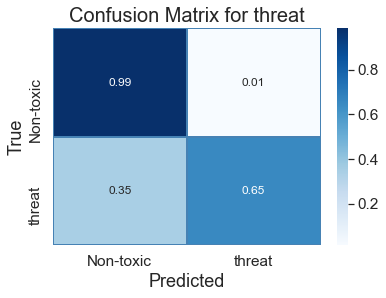

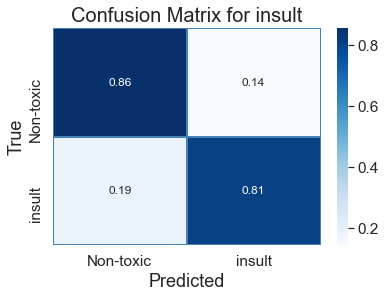

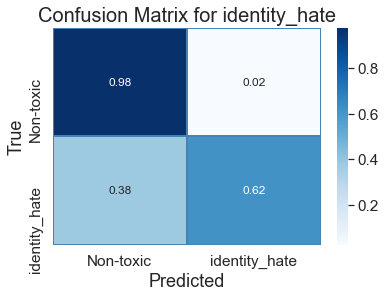

,Accuracy Score,Recall Score,Precision Score,F1 Score
toxic,0.840000,0.776667,0.889313,0.829181
severe_toxic,0.854754,0.862213,0.849794,0.855959
obscene,0.883667,0.850667,0.910778,0.879697
threat,0.912844,0.652778,0.930693,0.767347
insult,0.832333,0.808667,0.848845,0.828269
identity_hate,0.896462,0.616114,0.875421,0.723227


In [255]:
# use tf-idf vectoriser instead of Count Vectoriser and changing max_df parameter to .65

tfidf_exp3_1 = TfidfVectorizer(ngram_range=(1,1), max_features=3500,max_df=.65)

data_scor_exp3_1= pd.DataFrame()

for data in data_final:
    train_data, test_data = train_test_split(data, stratify=data[data.columns.values[2]],test_size=0.30)
    data_scor=split_vec_model_2(data,tfidf_exp3_1,train_data,test_data,rf,data.columns.values[2])
    data_scor_exp3_1=pd.concat([data_scor_exp3_1,data_scor])
    
display(data_scor_exp3_1)

##### Observation

In [260]:
# Compare the F1_Score of CountVectoiser and two variations of Tfidf vectoriser
df_comp_score = pd.concat([data_scor_exp2_1['F1 Score'],data_scor_exp3['F1 Score'],data_scor_exp3_1['F1 Score']],axis=1,keys=["F1 Score (CountVec)","F1 Score (tfidf-1)","F1 Score (tfidf-2)"])
display(df_comp_score)

,F1 Score (CountVec),F1 Score (tfidf-1),F1 Score (tfidf-2)
toxic,0.842291,0.830430,0.829181
severe_toxic,0.875883,0.861570,0.855959
obscene,0.866029,0.879068,0.879697
threat,0.818182,0.741036,0.767347
insult,0.843189,0.832930,0.828269
identity_hate,0.715447,0.693410,0.723227


Text(0.5, 1.0, 'F1 Score for Different Vectorisation')

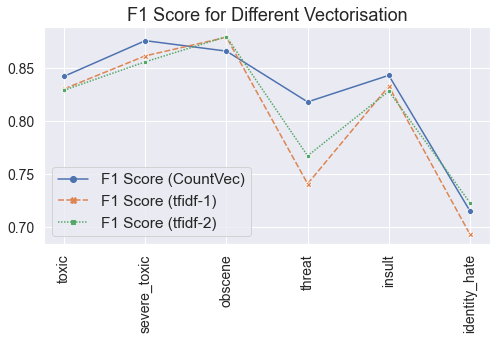

In [275]:
# Plot the comparison in a line graph for better understanding
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_comp_score, markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score for Different Vectorisation', fontsize=18)

### Conclusion

From experimenting with two different vectorisation technique CountVectoriser and tfidf vectoriser we can conclude that there is no considerable change in the output of modelling and CountVectoriser still show larger output performance with minute difference in f1 score when compared to model trained using tfidf vectoriser

Considering above observation we can finalise to take CountVectoriser for our toxic comment classification modelling 

### Experiment Setup - 4

#### Experimentation with two models

#### Objective

In this setup we will be experimenting with one more model **Linear Support Vector Classification** and will compare the result with the output we got from previous experiments using this model.

***A Linear Support Vector Classifier will fits our data and returns a finest hyperplane that classifies or categories our data***

In this experimentation we will do different variation in LinearSVC model to find the best setup with more f1score.

**1) Linear SVC with basic parameters**
    
    Other methods used based on previous observations are:
    
    * Train_Test_Split = Stratified method with 30% Test data size
    * Vectorisation = CountVectoriser with 3500 as max_feature and using Unigram alone
    

In [297]:
# Define LinearSVC with basic parameters
svc = LinearSVC()

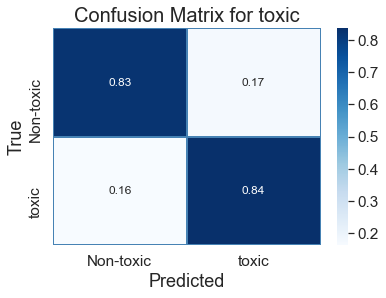

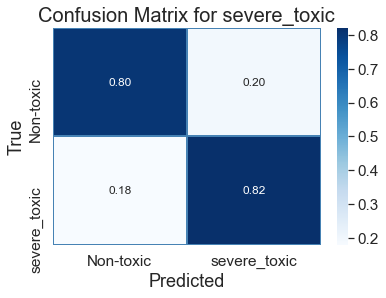

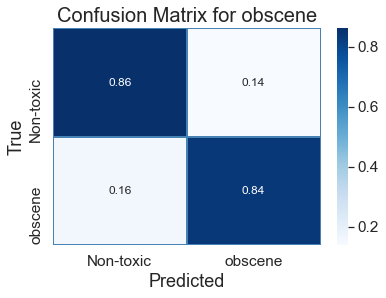

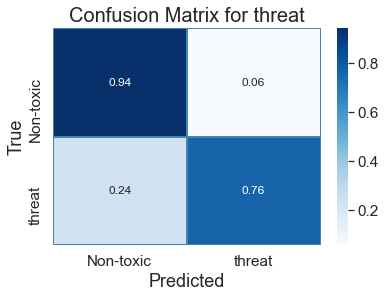

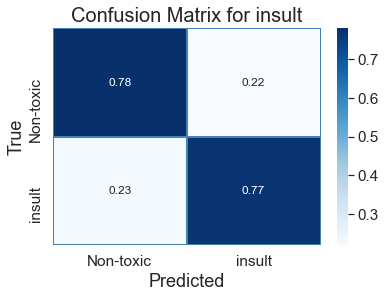

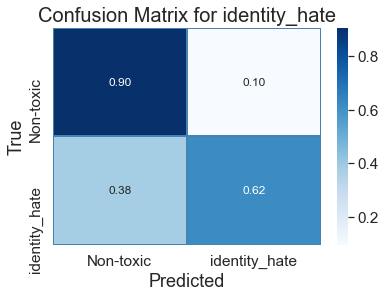

,Accuracy Score,Recall Score,Precision Score,F1 Score
toxic,0.831667,0.838000,0.827518,0.832726
severe_toxic,0.811912,0.820459,0.806982,0.813665
obscene,0.850000,0.837333,0.859097,0.848076
threat,0.903670,0.763889,0.791367,0.777385
insult,0.775000,0.770000,0.777778,0.773869
identity_hate,0.841311,0.618483,0.644444,0.631197


In [299]:
# Apply modeling and evaluation for our new model

data_scor_exp4= pd.DataFrame()

for data in data_final:
    train_data, test_data = train_test_split(data, stratify=data[data.columns.values[2]],test_size=0.30)
    data_scor = split_vec_model_2(data,cv_exp2_1,train_data,test_data,svc,data.columns.values[2])
    data_scor_exp4=pd.concat([data_scor_exp4,data_scor])
    
display(data_scor_exp4)

**2) Linear SVC with parameters**

Parameters used are :

* C=5            - Regularisation Parameter
* random_state=42 - Controls the pseudo random number generation for shuffling
* tol=1e-5       - Tolerance for stopping criteria

In [305]:
svc2 = LinearSVC(C=5,random_state=42, tol=1e-5)

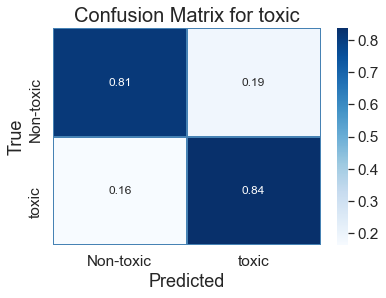

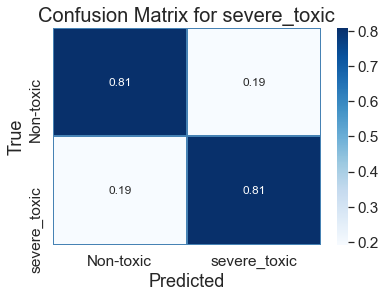

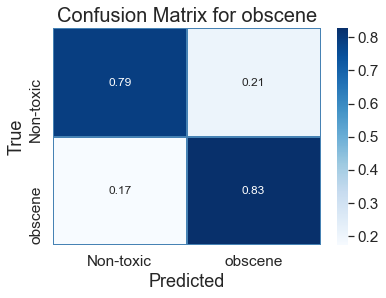

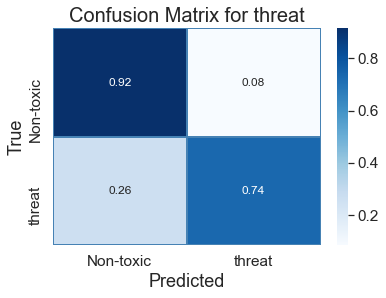

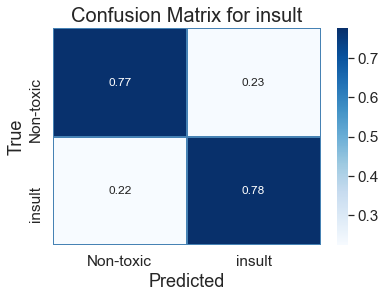

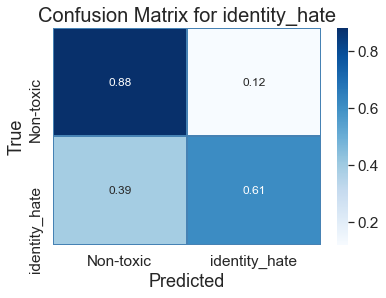

,Accuracy Score,Recall Score,Precision Score,F1 Score
toxic,0.825667,0.838000,0.817827,0.827791
severe_toxic,0.809822,0.810021,0.810021,0.810021
obscene,0.810667,0.828667,0.799871,0.814014
threat,0.877676,0.736111,0.716216,0.726027
insult,0.775333,0.776667,0.774601,0.775632
identity_hate,0.824142,0.613744,0.596774,0.605140


In [306]:
data_scor_exp4_1= pd.DataFrame()

for data in data_final:
    train_data, test_data = train_test_split(data, stratify=data[data.columns.values[2]],test_size=0.30)
    data_scor = split_vec_model_2(data,cv_exp2_1,train_data,test_data,svc2,data.columns.values[2])
    data_scor_exp4_1=pd.concat([data_scor_exp4_1,data_scor])
    
display(data_scor_exp4_1)

**3) Linear SVC with parameters_2**

Parameters used are :

* C=1                     - Regularisation Parameter
* class_weight='balanced' - Controls the pseudo random number generation for shuffling
* random_state=42         - Controls the pseudo random number generation for shuffling
* tol=1e-5                - Tolerance for stopping criteria

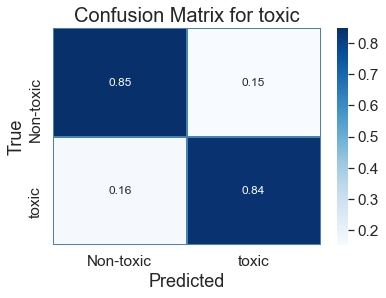

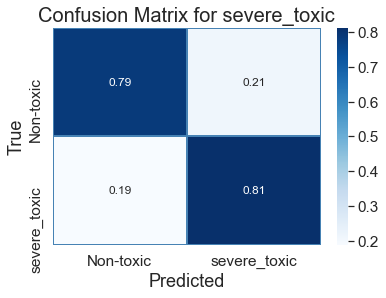

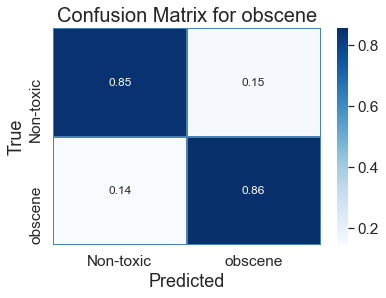

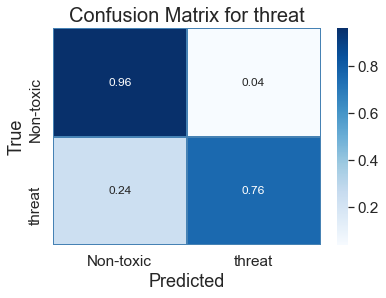

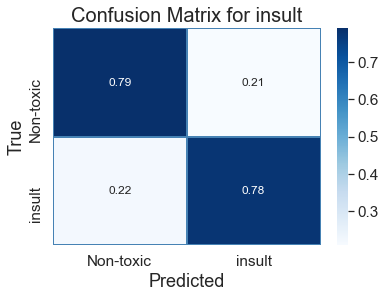

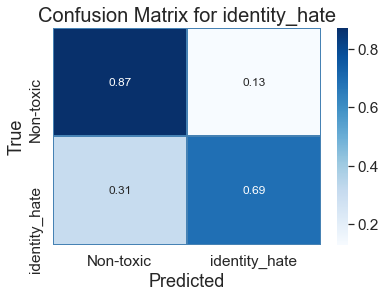

,Accuracy Score,Recall Score,Precision Score,F1 Score
toxic,0.844333,0.840000,0.847344,0.843656
severe_toxic,0.799373,0.812109,0.792261,0.802062
obscene,0.853000,0.858000,0.849505,0.853731
threat,0.917431,0.756944,0.851562,0.801471
insult,0.784000,0.777333,0.787838,0.782550
identity_hate,0.831426,0.689573,0.601240,0.642384


In [308]:
# creating model with C=1 and class weight as balanced

svc3 = LinearSVC(C=1, class_weight='balanced',tol=1e-5)

data_scor_exp4_2=pd.DataFrame()

for data in data_final:
    train_data, test_data = train_test_split(data, stratify=data[data.columns.values[2]],test_size=0.30)
    data_scor = split_vec_model_2(data,cv_exp2_1,train_data,test_data,svc3,data.columns.values[2])
    data_scor_exp4_2=pd.concat([data_scor_exp4_2,data_scor])
    
display(data_scor_exp4_2)

In [309]:
svc3.get_params()

{'C': 1,
 'class_weight': 'balanced',
 'dual': True,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'loss': 'squared_hinge',
 'max_iter': 1000,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'random_state': None,
 'tol': 1e-05,
 'verbose': 0}

## Hyper Parameter Tuning

We can check for best parameter of linearSVC using hyper parameter tuning. GridSearchCv method is used in this method to find the best parameter from the given set of parameter values

In [324]:
# Hyper parameter tuning of LinearSVC using GridSearchCV
svc_classifier = LinearSVC()
X_train_grid = cv_exp2_1.fit_transform(toxic_data_final.comment_text)
cros_val = StratifiedKFold(n_splits=5)
param_distributions = {"C":[0.1,1,0.5, 1,5, 10, 100, 1000],"class_weight" : [None,'balanced']}
clf = GridSearchCV(svc_classifier,param_distributions,cv=cros_val, return_train_score=False, verbose=True)
clf.fit(X_train_grid,toxic_data_final['toxic'])


Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:   14.3s finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LinearSVC(),
             param_grid={'C': [0.1, 1, 0.5, 1, 5, 10, 100, 1000],
                         'class_weight': [None, 'balanced']},
             verbose=True)

In [326]:
df_hyper_tuning = pd.DataFrame(clf.cv_results_)
display(df_hyper_tuning.loc[:,['param_C','param_class_weight','mean_test_score']])

,param_C,param_class_weight,mean_test_score
0,0.1,None,0.8591
1,0.1,balanced,0.8591
2,1,None,0.8390
3,1,balanced,0.8390
4,0.5,None,0.8476
5,0.5,balanced,0.8476
6,1,None,0.8390
7,1,balanced,0.8388
8,5,None,0.8237
9,5,balanced,0.8233


In [327]:
clf.best_params_

{'C': 0.1, 'class_weight': None}

We got the Best parameter value for **C=0.1** and **class_weight = None**

* Now train and evaluate the model LinearSVC using these parameter to see the result.

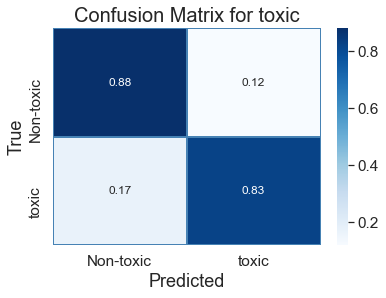

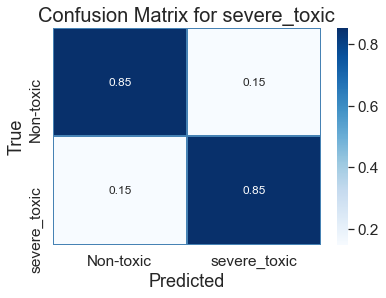

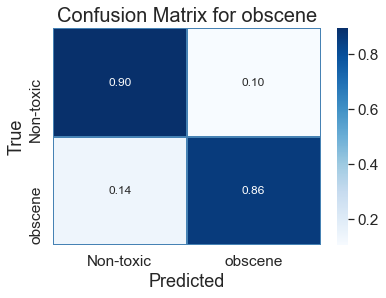

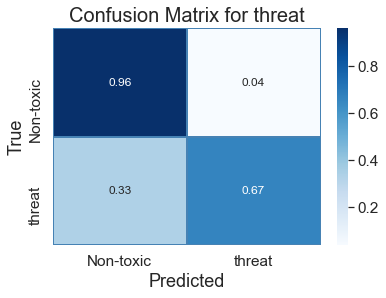

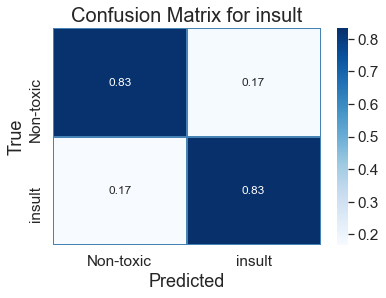

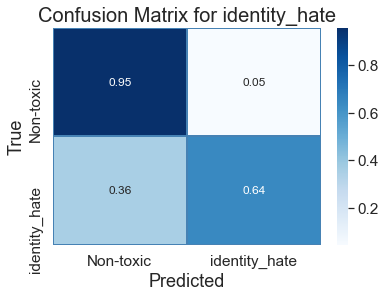

,Accuracy Score,Recall Score,Precision Score,F1 Score
toxic,0.853667,0.826000,0.874382,0.849503
severe_toxic,0.853710,0.853862,0.853862,0.853862
obscene,0.879000,0.861333,0.892882,0.876824
threat,0.899083,0.666667,0.842105,0.744186
insult,0.830667,0.833333,0.828912,0.831117
identity_hate,0.886056,0.642180,0.799410,0.712221


In [329]:
# creating model with C=1 and class weight as balanced

svc4 = LinearSVC(C=0.1, class_weight=None,tol=1e-5)

data_scor_exp4_3=pd.DataFrame()

for data in data_final:
    train_data, test_data = train_test_split(data, stratify=data[data.columns.values[2]],test_size=0.30)
    data_scor = split_vec_model_2(data,cv_exp2_1,train_data,test_data,svc4,data.columns.values[2])
    data_scor_exp4_3=pd.concat([data_scor_exp4_3,data_scor])
    
display(data_scor_exp4_3)

#### Observation
 Observe the F1 score from all combinations

In [334]:
# Compare the F1_Score of CountVectoiser and two variations of Tfidf vectoriser
df_comp_score = pd.concat([data_scor_exp4['F1 Score'],data_scor_exp4_1['F1 Score'],data_scor_exp4_2['F1 Score'],data_scor_exp4_3['F1 Score'],data_scor_exp2_1['F1 Score']],axis=1,keys=["F1 Score(LinearSVC_1)","F1 Score(LinearSVC_2)","F1 Score(LinearSVC_3)","F1 Score(LinearSVC_4)","F1 Score(Random Forest)"])
display(df_comp_score)

,F1 Score(LinearSVC_1),F1 Score(LinearSVC_2),F1 Score(LinearSVC_3),F1 Score(LinearSVC_4),F1 Score(Random Forest)
toxic,0.832726,0.827791,0.843656,0.849503,0.842291
severe_toxic,0.813665,0.810021,0.802062,0.853862,0.875883
obscene,0.848076,0.814014,0.853731,0.876824,0.866029
threat,0.777385,0.726027,0.801471,0.744186,0.818182
insult,0.773869,0.775632,0.782550,0.831117,0.843189
identity_hate,0.631197,0.605140,0.642384,0.712221,0.715447


Text(0.5, 1.0, 'F1 Score for Different Vectorisation')

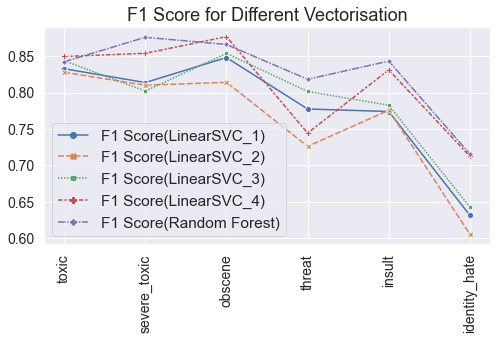

In [335]:
# Plot the comparison in a line graph for better understanding
plt.figure(figsize=(8, 4))
sns.lineplot(data=df_comp_score, markers=True)
plt.xticks(rotation='90', fontsize=14)
plt.yticks(fontsize=14)
plt.legend(loc='best')
plt.title('F1 Score for Different Vectorisation', fontsize=18)

#### Conclusion

Analysing the output from our variations for LinearSVC model and output of RandomForest model we can conclude that Random forest is showing better F1 score for most of the labels and the same can be taken as our model for this project 

## Final Observations

We have done experimentation in various option at different steps of our project.Main issues we faced was the usage of larger dataset and the dataset with class imbalance issue. Initially I tried to start the project with our entire datset but in preprocessing stage itself RAM allocation issue was thrown and also recursion error. After evaluation,we as a group decided to reduce the number of data entries by removing rows that are not much significant in the model training. During the second phase of the process after a one complete evaluation we came across another issue due to data imbalance in each label which has been removed by the method explained in final part of the experiment setup - 1. After each experiment we took the one option that give maximum efficiency for our model. Summarising the options from our experiments our final options that give maximum accuracy for the project are.

   1. **Stemming** for converting words in different form to a base form
   2. **Stratified test split** For splitiing our dataset to train and test
   3. **CountVectoriser** as the vectoriser to convert our text data to vectors with Unigram alone (1,1) and max_feature as 3500
   4. **RandomForest** Classifier with number of trees = 200 and criterion= entropy to measure the quality of the split as our algorithm.
   


## Overall Attempt and Outcome

After modeling and evaluating the given data using 2 different algorithms and various preprocessing methods I have selected the best option that will give the best result for our model. Best result was considered by analysing accuracy, recall, precision and F1 score of each setup in which F1 score is given more importance. Following are the analysis we made at each stage of the project.

* Removing the data imbalance issue increased the model efficiency considerably. 
* Stemming and lemmatisation method was done independently but they did'nt show any considerable change in the model output. Stemming was taken because of its lesser processing time.
* CountVectoriser was given the best result within which increasing the ngram made an inverse effect in the f1 score. Inreasing max_feature parameter also increased the output accuracy of the model. 
* Splitting the dataset for training and testing was initially done using simple hold out method like selecting 60:40 ratio of total data for testing and training. But when splitting was done using the stratified method we were able to see a rise in the evaluation parameter values.
* Two different models were trained and evaluated, from which RandomForest classifier give the best result compared to Linear Support Vector Machine Model.
* Hyper Parameter tuning was also done on LinearSVC model to get the best parameters. But still RandomForest model displayed the best result except for two labels.

Following the experimentations, our aim to classify the toxic comments was successful with an average accuracy above 80 percent for each label. Pulling out these conversations from various discussion pages will provide freedom to the common people for expressing their ideas and to seek help on any topic from experts. 

## References

* Confusion Matrix Visualisation - https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
* RandomForestClassifier      - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
* LinearSVC                   - https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
* Vectorisation Techniques- https://medium.com/@wenxuan0923/feature-extraction-from-text-using-countvectorizer-tfidfvectorizer-9f74f38f86cc